# Flexible Composition and Abstraction in Dynamical Closed-loop Control
We base this exposition of flexibly composable, optimal, "passive-active" (KL) control on the following papers:
* Todorov, E. (2006). Linearly-solvable Markov decision problems. Advances in Neural Information Processing Systems, 19. [link](https://proceedings.neurips.cc/paper_files/paper/2006/file/d806ca13ca3449af72a1ea5aedbed26a-Paper.pdf)
* Todorov, E. (2009). Efficient computation of optimal actions. Proceedings of the National Academy of Sciences of the United States of America, 106(28), 11478–11483. [doi](https://doi.org/10.1073/pnas.0710743106)
* Todorov, E. (2009). Compositionality of optimal control laws. Advances in Neural Information Processing Systems, 22. [link](https://papers.nips.cc/paper_files/paper/2009/file/3eb71f6293a2a31f3569e10af6552658-Paper.pdf)
* Todorov, E. (2009). Eigenfunction approximation methods for linearly-solvable optimal control problems. 2009 IEEE Symposium on Adaptive Dynamic Programming and Reinforcement Learning, 161–168. [doi](https://doi.org/10.1109/adprl.2009.4927540)

## 1. Problem Overview
The main idea being explored here is Kullback-Leibler (KL) control, with the intention to later investigate how optimal control aligns with passive system dynamics, where useful. In this regard, Todorov (2006, 2009) formulates optimal controlled dynamics in terms of passive dynamics and an exponentiated cost-to-go function which not only satisfies but also linearizes the Bellman equation for optimality, thus greatly simplifying and opening the scope for flexibly composing different control constraints and objectives. Here, for the sake of exposition of this elegant reformulation, we consider a toy problem of reaching (using a two-link arm) in the absence as well as presence of a blocking obstacle. We would make this formulation work for simple reaching first, and then make it reach while avoiding an obstacle to demonstrate compositional control. A rectangular obstacle will be set to block direct point-to-point reaching of the end-effector to the goal, requiring it to move around the obstacle while optimally redirecting momentum.

 Each step in time will incur a running cost to encourage faster completion of the reach and there will be terminal costs at the obstacle and target to make it avoid colliding and instead complete the reach to the target as closely as possible with a smooth stop (by regulating end-effector velocity). We will solve this as a finite-horizon optimal control problem to maintain consistency with the primary formulation by Todorov (2009, PNAS), however the same framework supports other formulations (infinite horizon, average cost, discounted) as detailed in the same paper.

## 2. Problem Setup
Let the two-link arm have joint angles $\theta = (\theta_1,\theta_2)$, joint velocities $\dot{\theta}$, and state $x = \begin{bmatrix}\theta, \dot{\theta}\end{bmatrix}^\top \in \mathbb{R}^4$. The continuous-time, torque-driven dynamics are $$ M(\theta)\ddot{\theta} + C(\theta,\dot{\theta})\dot{\theta} + b\dot{\theta} = \tau,$$ with inertia $M(\theta) \succ 0$, Coriolis matrix $C(\theta,v)$, damping $b \geq 0$, and joint torques $\tau \in \mathbb{R}^2$. We define passive dynamics to be the torque-free acceleration $$\ddot{\theta}_{\tau=0}(\theta,\dot{\theta}) \coloneqq M(\theta)^{-1}\left(-C(\theta,\dot{\theta})\dot{\theta} - b\dot{\theta}\right).$$ Then the state dynamics are affine in $\tau$ $$\dot{x} = \underbrace{\begin{bmatrix} \dot{\theta}\\ \ddot{\theta}_{\tau=0}(\theta,\dot{\theta}) \end{bmatrix}}_{\eqqcolon A(x)} + \underbrace{\begin{bmatrix} 0_{2\times 2}\\ M(\theta)^{-1} \end{bmatrix}}_{\eqqcolon B(x)}\tau.$$ With a fixed step $\Delta t$, the Euler step gives the deterministic mean next state $$F(x,\tau) \coloneqq \begin{bmatrix}\theta + \dot{\theta}\Delta t \\ \dot{\theta} + \left(\ddot{\theta}_{\tau=0}(\theta,\dot{\theta}) + M(\theta)^{-1}\tau\right)\Delta t \end{bmatrix}.$$

For efficient computation and discretization of passive and active dynamics, we define the passive kernel ($\tau=0; P^0$) and a controlled kernel ($\tau\neq 0; P^\tau$) as $$\begin{align*}p(x^\prime|x) &\approx \mathcal{N}\left(x^\prime; F(x,0), \Sigma(x)\Delta t\right) \\ u(x^\prime \mid x) = p(x^\prime \mid x, \tau) &\approx \mathcal{N}\left(x^\prime; F(x,\tau), \Sigma(x)\Delta t\right),\end{align*}$$ where the process noise is modelled as a small diffusion with covariance $\Sigma(x)\Delta t$ due to Gaussian white noise in the torque space $\eta_\tau \sim \mathcal{N}(0, \sigma_\tau^2I)$ which will only allow non-zero entries along joint velocities $$\Sigma_{\dot{\theta}} = \sigma_\tau^2 M(\theta)^{-1}M(\theta)^{-\top}\quad \text{such that} \quad \Sigma(x) = \begin{bmatrix}0_{2\times 2} & 0\\0 & \Sigma_{\dot{\theta}}(x)\end{bmatrix}.$$ Furthermore, to have smoother state transitions and subsequent flow of desirability/costs/rewards between quantized states in the MDP, we use multilinear interpolation to spread the probability mass appropriately across 16 neighbors (cell vertices in a uniform 4D grid). For instance, let $\mu(x,\tau) = F(x,\tau)$ be the next state under Euler integration. Then, the fractional coordinate of $\mu$ within its enclosing grid cell along each dimension $d \in \{1,2,3,4\}$ will be $$\alpha_d = \frac{\mu_d - \text{grid}_\text{lower}}{\text{grid}_\text{upper} - \text{grid}_\text{lower}} \in [0,1].$$ The probability mass assigned to each of the 16 cell vertices $n \in \{0,1\}^4$ is the multilinear weight $$w_n(\mu) = \prod_{d=1}^4 \left(\alpha_d^{n_d}\,(1-\alpha_d)^{1-n_d}\right),$$ which yields row-stochastic, strictly local discrete transition kernels — $P^0$ for passive dynamics and $P^\tau$ for active/controlled dynamics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, eye as speye, diags
from scipy.sparse.linalg import spsolve
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

# dynamics parameters for 2-link arm
class ArmDynamics:
    """two-link arm dynamics with passive and controlled kernels"""
    
    def __init__(self, l1=1.0, l2=1.0, m1=1.0, m2=1.0, b=0.1, dt=0.01, sigma_tau=0.1):
        # arm parameters
        self.l1, self.l2 = l1, l2  # link lengths
        self.m1, self.m2 = m1, m2  # link masses
        self.b = b  # damping coefficient
        self.dt = dt  # time step
        self.sigma_tau = sigma_tau  # torque noise std
        
    def inertia_matrix(self, theta):
        """compute inertia matrix M(theta)"""
        t1, t2 = theta
        m11 = self.m1 * self.l1**2/3 + self.m2 * (self.l1**2 + self.l2**2/3 + self.l1*self.l2*np.cos(t2))
        m12 = self.m2 * (self.l2**2/3 + self.l1*self.l2*np.cos(t2)/2)
        m22 = self.m2 * self.l2**2/3
        return np.array([[m11, m12], [m12, m22]])
    
    def coriolis_matrix(self, theta, theta_dot):
        """compute coriolis matrix C(theta, theta_dot)"""
        t1, t2 = theta
        td1, td2 = theta_dot
        c11 = -self.m2 * self.l1 * self.l2 * np.sin(t2) * td2 / 2
        c12 = -self.m2 * self.l1 * self.l2 * np.sin(t2) * (td1 + td2) / 2
        c21 = self.m2 * self.l1 * self.l2 * np.sin(t2) * td1 / 2
        c22 = 0
        return np.array([[c11, c12], [c21, c22]])
    
    def passive_accel(self, theta, theta_dot):
        """passive (torque-free) acceleration"""
        m = self.inertia_matrix(theta)
        c = self.coriolis_matrix(theta, theta_dot)
        return -np.linalg.solve(m, c @ theta_dot + self.b * theta_dot)
    
    def euler_mean(self, x, tau=None):
        """euler integration for mean next state"""
        theta, theta_dot = x[:2], x[2:]
        if tau is None:
            tau = np.zeros(2)
        
        m = self.inertia_matrix(theta)
        theta_ddot = self.passive_accel(theta, theta_dot) + np.linalg.solve(m, tau)
        
        # euler step
        theta_new = theta + theta_dot * self.dt
        theta_dot_new = theta_dot + theta_ddot * self.dt
        return np.concatenate([theta_new, theta_dot_new])
    
    def noise_covariance(self, x):
        """process noise covariance Sigma(x) * dt"""
        theta = x[:2]
        m = self.inertia_matrix(theta)
        m_inv = np.linalg.inv(m)
        sigma_vel = self.sigma_tau**2 * m_inv @ m_inv.T
        sigma = np.zeros((4, 4))
        sigma[2:, 2:] = sigma_vel * self.dt
        return sigma

# discretization and mdp setup
class GridMDP:
    """discretized mdp for kl control"""
    
    def __init__(self, dynamics, grid_bounds, grid_size):
        self.dyn = dynamics
        self.bounds = np.array(grid_bounds)  # [[min, max] for each dim]
        self.grid_size = np.array(grid_size)  # number of points per dim
        
        # create grid
        self.create_grid()
        self.n_states = np.prod(self.grid_size)
    
    def create_grid(self):
        """create state space grid"""
        axes = []
        for i in range(4):
            a0, a1 = float(self.bounds[i,0]), float(self.bounds[i,1])
            n = int(self.grid_size[i])
            if i < 2 and np.isclose(a1 - a0, 2*np.pi, atol=1e-9):
                ax = np.linspace(a0, a1, n, endpoint=False)  # 2pi/n increments
            else:
                ax = np.linspace(a0, a1, n)
            axes.append(ax)
        self.grid_axes = axes
        self.grid_mesh = np.meshgrid(*axes, indexing='ij')
        self.states = np.array([g.ravel() for g in self.grid_mesh]).T
    
    def is_boundary_continuous(self, x):
        """boolean check over continuous valued input space"""
        return self.is_boundary[self.index_to_flat(self.nearest_index(x))]

    def state_to_index(self, x):
        """convert continuous state to grid index"""
        idx = []
        for d in range(4):
            ax = self.grid_axes[d]
            n = len(ax)
            xi = x[d]
            if d < 2:  # periodic
                dx = ax[1] - ax[0]
                pos = ((xi - ax[0]) / dx) % n
                j = int(np.floor(pos))  # left index
            else:  # non-periodic
                if xi <= ax[0]: j = 0
                elif xi >= ax[-1]: j = n-1
                else: j = np.searchsorted(ax, xi)
            idx.append(j)
        return tuple(idx)
    
    def nearest_index(self, x):
        """find nearest grid index with periodic angle handling"""
        idx = []
        for d in range(4):
            ax = self.grid_axes[d]
            n = len(ax)
            xi = x[d]
            if d < 2:
                # fractional position on the grid
                dx = ax[1] - ax[0]
                pos = ((xi - ax[0]) / dx) % n
                j = int(np.floor(pos + 0.5)) % n
            else:
                # nearest position on the grid
                j = int(np.argmin(np.abs(ax - xi)))
            idx.append(j)
        return tuple(idx)
    
    def index_to_flat(self, idx):
        """convert grid index to flattened index"""
        return np.ravel_multi_index(idx, self.grid_size)
    
    def flat_to_index(self, flat_idx):
        """convert flattened index to grid index"""
        return np.unravel_index(flat_idx, self.grid_size)
    
    def multilinear_weights(self, x_next):
        """compute multilinear interpolation for state vertices in the enclosing hypercube with periodic angles"""
        index_pairs = []
        alphas = []
        
        for d in range(4):
            ax = self.grid_axes[d]
            n = len(ax)
            xi = x_next[d]
            
            if d < 2:  # angle dimensions - periodic
                # uniform grid spacing (since endpoint=False)
                dx = ax[1] - ax[0]
                # continuous position in grid units [0, n)
                pos = ((xi - ax[0]) / dx) % n
                # left cell index and interpolation fraction
                j = int(np.floor(pos))
                alpha = pos - j
                # store index pair with wraparound
                j_right = (j + 1) % n
                index_pairs.append((j, j_right))
                
            else:  # velocity dimensions - non-periodic
                if xi <= ax[0]:
                    j = 0
                    alpha = 0.0
                    j_right = 1
                elif xi >= ax[-1]:
                    j = n - 2
                    alpha = 1.0
                    j_right = n - 1
                else:
                    j = np.searchsorted(ax, xi) - 1
                    j = np.clip(j, 0, n - 2)
                    alpha = (xi - ax[j]) / (ax[j+1] - ax[j])
                    j_right = j + 1
                index_pairs.append((j, j_right))
            
            alphas.append(alpha)
        
        # enumerate 16 hypercube vertices with proper index selection
        weights = {}
        for vertex in range(16):
            w = 1.0
            indices = []
            for d in range(4):
                # extract bit for this dimension
                use_right = (vertex >> d) & 1
                # select left or right index from the pair
                idx = index_pairs[d][use_right]
                indices.append(idx)
                # accumulate weight
                if use_right:
                    w *= alphas[d]
                else:
                    w *= (1 - alphas[d])
            
            if w > 1e-12:  # threshold small weights
                flat_idx = self.index_to_flat(tuple(indices))
                weights[flat_idx] = weights.get(flat_idx, 0.0) + w
        
        # normalize
        total = sum(weights.values())
        if total > 0:
            weights = {k: v/total for k, v in weights.items()}
        
        return weights
    
    def _vel_blur(self, base_weights, x_center, eps=1e-12):
        """get torque noise spread along joint velocity dims"""
        if not base_weights:
            return {}

        # per-step velocity covariance at x_center
        Sigma = self.dyn.noise_covariance(x_center)[2:, 2:]
        std1 = float(np.sqrt(max(Sigma[0, 0], eps)))
        std2 = float(np.sqrt(max(Sigma[1, 1], eps)))

        # convert to index-space stds (cells)
        dv1 = float(self.grid_axes[2][1] - self.grid_axes[2][0])
        dv2 = float(self.grid_axes[3][1] - self.grid_axes[3][0])
        s1 = max(std1 / (dv1 + eps), 1e-6)
        s2 = max(std2 / (dv2 + eps), 1e-6)

        # compact separable Gaussian kernels
        r1 = max(1, int(np.ceil(2.5 * s1)))
        r2 = max(1, int(np.ceil(2.5 * s2)))
        o1 = np.arange(-r1, r1 + 1)
        o2 = np.arange(-r2, r2 + 1)
        k1 = np.exp(-0.5 * (o1 / s1) ** 2); k1 /= k1.sum()
        k2 = np.exp(-0.5 * (o2 / s2) ** 2); k2 /= k2.sum()

        spreads = {}
        for j, w in base_weights.items():
            i0, i1, i2, i3 = self.flat_to_index(j)
            for a, wa in zip(o1, k1):
                ii2 = i2 + a
                if not (0 <= ii2 < self.grid_size[2]): 
                    continue
                for b, wb in zip(o2, k2):
                    ii3 = i3 + b
                    if not (0 <= ii3 < self.grid_size[3]): 
                        continue
                    jj = self.index_to_flat((i0, i1, ii2, ii3))
                    spreads[jj] = spreads.get(jj, 0.0) + w * wa * wb

        # normalize
        s = sum(spreads.values())
        if s <= 0:
            return {}
        for k in list(spreads.keys()):
            spreads[k] /= s
        return spreads

    def _kernel_from_mean(self, mu, x):
        """apply discretization of torque noise blur N(mu, Σ(x)Δt)"""
        w = self.multilinear_weights(mu)
        return self._vel_blur(w, x)

    def build_passive_kernel(self):
        """build passive transition kernel P^0"""
        n = self.n_states
        rows, cols, data = [], [], []
        
        for i in range(n):
            x = self.states[i]
            mu = self.dyn.euler_mean(x, tau=None)
            w_map = self._kernel_from_mean(mu, x)
            
            for j, w in w_map.items():
                rows.append(i)
                cols.append(j)
                data.append(w)
        
        self.p0 = csr_matrix((data, (rows, cols)), shape=(n, n))
        
        # normalize rows
        row_sums = self.p0.sum(axis=1).A.ravel()
        row_sums[row_sums == 0] = 1
        self.p0 = diags(1/row_sums) @ self.p0
    
    def set_costs_and_boundaries(self, target, obstacle=None, q_step=2.0, q_vel_wt=0.5, vel_tol=0.2, 
                                 q_brake=3.0, brake_r=0.15):
        """set state costs and boundary conditions with proper scaling"""
        n = self.n_states
        self.q = np.zeros(n)
        self.is_boundary = np.zeros(n, dtype=bool)
        self.boundary_cost = np.zeros(n)
        dt = getattr(self.dyn, 'dt', 0.01)
        
        def _smoothstep(a, b, r):
            """1 at r<=a, 0 at r>=b, smooth in between."""
            if r <= a: return 1.0
            if r >= b: return 0.0
            t = (b - r) / max(b - a, 1e-12)
            return t*t*(3 - 2*t)

        edge_pad = 1  # boundary layer thickness
        for i in range(n):
            idx_tuple = self.flat_to_index(i)
            
            # check if any dimension is near boundary
            is_edge = False
            for d, j in enumerate(idx_tuple):
                if j <= edge_pad or j >= self.grid_size[d] - 1 - edge_pad:
                    # skip angle dimensions for edge check (since they're periodic)
                    if d >= 2:
                        is_edge = True
                        break
            
            # first mark edge states as boundaries
            if is_edge:
                self.is_boundary[i] = True
                self.boundary_cost[i] = 20.0
                continue
            
            # now check problem-specific boundaries
            x = self.states[i]
            pos = self.forward_kinematics(x[:2])
            
            # target boundary with velocity regulation
            at_goal = np.linalg.norm(pos - target) < 0.2 # goal radius
            slow_enough = np.linalg.norm(x[2:]) <= vel_tol if vel_tol is not None else True
            
            if at_goal and slow_enough:
                self.is_boundary[i] = True
                vel_cost = 0.1 * np.dot(x[2:], x[2:])
                self.boundary_cost[i] = vel_cost
                continue
            
            # obstacle boundary
            if obstacle is not None and self.in_obstacle(pos, obstacle):
                self.is_boundary[i] = True
                self.boundary_cost[i] = 500.0
                continue
            
            # soft repel based on distance to rectangular obstacle
            if obstacle is not None:
                xm, xM, ym, yM = obstacle
                dx = max(xm - pos[0], 0.0, pos[0] - xM)
                dy = max(ym - pos[1], 0.0, pos[1] - yM)
                dist = np.hypot(dx, dy)
                self.q[i] += 10.0 * np.exp(-dist/1.5) * dt
            
            # need for braking near goal
            brake_radius = 0.2 + brake_r
            speed = float(np.linalg.norm(x[2:]))
            tgt_dist = float(np.linalg.norm(pos - target))
            if tgt_dist <= brake_radius:
                w = _smoothstep(0.2, brake_radius, tgt_dist) # 1 near goal; 0 at brake
                self.q[i] += (q_brake*w*speed**2)*dt
            
            # interior running cost
            self.q[i] += (q_step + q_vel_wt * np.dot(x[2:], x[2:]))*dt
        
        self.interior = ~self.is_boundary
    
    def forward_kinematics(self, theta):
        """compute end-effector position"""
        t1, t2 = theta
        x = self.dyn.l1 * np.cos(t1) + self.dyn.l2 * np.cos(t1 + t2)
        y = self.dyn.l1 * np.sin(t1) + self.dyn.l2 * np.sin(t1 + t2)
        return np.array([x, y])
    
    def in_obstacle(self, pos, obstacle, margin=0.03):
        """check if position is inside rectangular obstacle"""
        x, y = pos
        x_min, x_max, y_min, y_max = obstacle
        return (x_min - margin) <= x <= (x_max + margin) and (y_min - margin) <= y <= (y_max + margin)

## 3. Computation of Optimal Control Laws
It can be shown that in KL control (see Todorov 2009, PNAS) the optimal "controlled" transition distribution is given by $$u^*(x^\prime\mid x) = \frac{p(x^\prime\mid x)z(x^\prime)}{\mathcal{G}[z](x)}, \quad \mathcal{G}[z](x)=\sum_{x^\prime} p(x^\prime \mid x)z(x^\prime) = \mathbb{E}_{x^\prime \sim p(\cdot\mid x)}\left[z(x^\prime)\right],$$ due to which the Bellman equation is greatly simplified and becomes linear in $z$ space $$z(x) = \exp(-q(x))\mathcal{G}[z](x), \quad x\in \mathcal{I}; \qquad z(x)=\exp(-f(x)), \quad x\in \mathcal{B}$$ where $\mathcal{I}$ is the set of all the interior states, $\mathcal{B}$ is a boundary (absorbing) set that includes a goal region (and any obstacle-contact region), $q(x)\ge 0$ is the running cost over internal states, $f(x)$ are terminal costs assigned on $\mathcal{B}$, and $z(x)$ can be interpreted as the "desirability" of state $x$ such that $z \coloneqq \exp(-v)$ where $v(x)$ is the optimal cost-to-go. The state desirabilities can be solved efficiently by ordering states as $(\mathcal{I}, \mathcal{B})$ in block matrix form $$z_I = M z_\mathcal{I} + N z_\mathcal{B}, \quad M = \operatorname{diag}(\exp(-q_\mathcal{I}))P^0_{\mathcal{I}\mathcal{I}}, \quad N = \operatorname{diag}(\exp(-q_\mathcal{I}))P^0_{\mathcal{I}\mathcal{B}},$$ which gives us $(I-M)z_\mathcal{I} = N z_\mathcal{B},$ a linear system for $z_\mathcal{I}$ with fixed $z_\mathcal{B} = \exp(-f_\mathcal{B})$.

Furthermore, due to linear Bellman optimality in $z$ space, multiple objectives or constraints can be easily composed together to form the final control law. Consider $K$ primitives sharing the same $p(\cdot\mid x)$ and $q(x)$, but with different terminal costs $f_k$, equivalently $z_{\mathcal{B},k}=\exp(-f_k)$, each solving $(I-M)z_{\mathcal{I},k} = N z_{\mathcal{B},k}$. Then for non-negative weights $w_k$ we have the composite state desirability which solves the same interior desirability equation with composite boundary desirabilities $$z(x)=\sum_{k} w_k z_k(x) \quad \text{and specifically} \quad z_\mathcal{B} = \sum_k w_k z_{\mathcal{B},k}.$$ The corresponding optimal controlled transition distribution is a state-dependent mixture $$u^*(\cdot|x) = \sum_{k=1}^K m_k(x)u_k^*(\cdot|x) \quad \text{where} \quad m_k(x) = \frac{w_k z_k(x)}{\sum_s w_s z_s(x)}.$$ As a side note, in our case of reaching in the absence and presence of a direct-path blocking obstacle, we will have to solve both problems independently due to a change in the boundary set $\mathcal{B}$.

### 3.1 From Optimal Transitions to Optimal Control
Since KL control only gives us the optimal controlled transition distribution, to infer the actual torque command $\tau^*(x)$ at each timestep, we can match the mean next state implied by $u^*$ (e.g. in Todorov 2009, IEEE ADPRL). Let $\mu(x^\prime; x) \coloneqq \mathbb{E}_{x^\prime\sim u^*(\cdot\mid x)}[x^\prime]$. Notice then, that the forward Euler step for joint velocities under torque $\tau$ obeys $$\dot{\theta}^\prime \approx \dot{\theta} + \left(\ddot{\theta}_{\tau=0}(\theta,\dot{\theta}) + M(\theta)^{-1}\tau\right)\Delta t.$$ Imposing mean matching on joint velocities, we get $$\tau^*(x) = M(\theta)\left(\frac{\mu(\dot{\theta}^\prime; x) - \dot{\theta}}{\Delta t} - \ddot{\theta}_{\tau=0}(\theta,\dot{\theta})\right).$$ We can clip the torque to actuator limits $\tau^*_{\text{clip}}(x) = \operatorname{clip}\left(\tau^*(x), -\tau_{\text{max}}, \tau_{\text{max}}\right)$. More generally, if the state update is $x^\prime \approx x + (A(x) + B(x)\tau)\Delta t$, then mean-matching yields $$\tau^*(x) = B(x)^\dagger\frac{\mu(x^\prime; x) - x - A(x)\Delta t}{\Delta t},$$ where $B^\dagger$ is the Moore–Penrose pseudoinverse. In our arm, $B(x)$ only affects joint velocities, yielding the simpler formula above.

### 3.2 Consistency Check
The controlled/active kernel $p_{\tau^*}(\cdot\mid x) \coloneqq p\left(\cdot\mid x,\tau^*(x)\right)$ will not generally match the optimal controlled kernel $u^*(\cdot\mid x)$ because we matched only the mean. A useful diagnostic is the per-state KL divergence $$D_{\mathrm{KL}}\left(u^*(\cdot\mid x)\mid\mid p_{\tau^*}(\cdot\mid x)\right) = \sum_{x'} u^*(x^\prime\mid x)\log\frac{u^*(x^\prime\mid x)}{p_{\tau^*}(x^\prime\mid x)}.$$ Lower values indicate that the commanded torque closely realizes the optimal controlled transition.

In [5]:
def solve_kl_control(mdp, lam=1.0):
    """solve linear system for stationary z to compute kl optimal controlled transitions"""
    n = mdp.n_states
    
    # partition states
    idx_i = np.where(mdp.interior)[0]
    idx_b = np.where(mdp.is_boundary)[0]
    n_i = len(idx_i)
    
    # extract submatrices
    p_ii = mdp.p0[idx_i, :][:, idx_i]
    p_ib = mdp.p0[idx_i, :][:, idx_b]
    
    # build m and n matrices with temperature scaling
    exp_neg_q = np.exp(-mdp.q[idx_i] / lam)
    M = diags(exp_neg_q) @ p_ii
    N = diags(exp_neg_q) @ p_ib
    
    # boundary desirabilities with temperature
    z_b = np.exp(-mdp.boundary_cost[idx_b] / lam)
    
    # solve (I - M)z_i = Nz_b
    z_i = spsolve(speye(n_i) - M, N @ z_b)
    
    # assemble full desirability
    z = np.zeros(n)
    z[idx_i] = z_i
    z[idx_b] = z_b
    
    # ensure interior is properly set
    mdp.interior = ~mdp.is_boundary
    
    return z

def compute_optimal_control(mdp, z, x_idx, eps=1e-12):
    """compute optimal torque at state index via mean matching"""
    
    if mdp.is_boundary[x_idx]:
        return np.zeros(2)  # absorb
    
    # u*(·|x)
    row = mdp.p0.getrow(x_idx)
    cols = row.indices
    p0   = row.data
    if cols.size == 0:
        return np.zeros(2)
    numer = p0 * z[cols]
    denom = float(numer.sum())
    if denom <= eps:
        return np.zeros(2)
    u = numer / denom

    # mean next state (under u*)
    mu = u @ mdp.states[cols]

    # mean-match **velocities** only
    x = mdp.states[x_idx]
    theta, theta_dot = x[:2], x[2:]
    mu_vel = mu[2:]

    m = mdp.dyn.inertia_matrix(theta)
    a0 = mdp.dyn.passive_accel(theta, theta_dot)
    tau = m @ ((mu_vel - theta_dot) / mdp.dyn.dt - a0)
    return tau

def _u_star_row(mdp, z, x_idx, eps=1e-12):
    """return (cols_u, probs_u) for u*(·|x_idx)"""
    if mdp.is_boundary[x_idx]:
        return np.array([], dtype=int), np.array([])
    
    row = mdp.p0.getrow(x_idx)
    cols = row.indices
    p0   = row.data
    
    if cols.size == 0:
        return np.array([], dtype=int), np.array([])
    numer = p0 * z[cols]
    denom = float(numer.sum())
    
    if denom <= eps:
        # degenerate: treat as zero-prob vector
        return np.array([], dtype=int), np.array([])
    u = numer / denom
    return cols, u

def _ptau_row(mdp, x_idx, tau, eps=1e-12):
    """return (cols_tau, probs_tau) for controlled kernel p(·|x_idx, tau)"""
    if mdp.is_boundary[x_idx]:
        return np.array([], dtype=int), np.array([])

    x_center = mdp.states[x_idx]
    x_next   = mdp.dyn.euler_mean(x_center, tau)
    w_map    = mdp._kernel_from_mean(x_next, x_center)

    if not w_map:
        return np.array([], dtype=int), np.array([])

    cols = np.fromiter(w_map.keys(), dtype=int, count=len(w_map))
    p    = np.fromiter(w_map.values(), dtype=float, count=len(w_map))
    s    = float(p.sum())

    if s <= eps:
        return np.array([], dtype=int), np.array([])
    p /= s
    return cols, p

def _align_to_union(cols_a, p_a, cols_b, p_b):
    """align two sparse distributions to their union support; return (pa_aligned, pb_aligned)"""
    all_cols = np.unique(np.concatenate([cols_a, cols_b])) if cols_a.size or cols_b.size else np.array([], dtype=int)
    if all_cols.size == 0:
        return np.array([]), np.array([])

    def gather(cols, vals):
        out = np.zeros(all_cols.size, dtype=float)
        if cols.size:
            m = {int(c): float(v) for c, v in zip(cols, vals)}
            for i, c in enumerate(all_cols):
                out[i] = m.get(int(c), 0.0)
        return out

    return gather(cols_a, p_a), gather(cols_b, p_b)

def _kl(p, q, eps=1e-12):
    """D_KL(p || q) with numerical safety; expects both p, q to be aligned and sum ~ 1"""
    if p.size == 0:
        return 0.0
    p = np.asarray(p, float); q = np.asarray(q, float)
    p = p / (p.sum() + eps)
    q = q / (q.sum() + eps)
    mask = p > eps
    return float(np.sum(p[mask] * (np.log(p[mask]) - np.log(q[mask] + eps))))

def compute_kl_optimal(mdp, z, x_idx, tau, eps=1e-12):
    """compute kl divergence between u* and p_tau for optimality diagnostics"""
    if mdp.is_boundary[x_idx]:
        return 0.0

    cols_u, u_dist   = _u_star_row(mdp, z, x_idx, eps=eps)
    cols_pt, p_tau   = _ptau_row(mdp, x_idx, tau, eps=eps)

    if u_dist.size == 0 or p_tau.size == 0:
        return 0.0

    u_aligned, p_aligned = _align_to_union(cols_u, u_dist, cols_pt, p_tau)
    return _kl(u_aligned, p_aligned, eps=eps)

def compute_kl_passive(mdp, x_idx, tau, eps=1e-12):
    """compute kl divergence between p_tau and passive p0 as a proxy for control effort"""
    if mdp.is_boundary[x_idx]:
        return 0.0

    # p0
    row = mdp.p0.getrow(x_idx)
    cols_p0 = row.indices
    p0      = row.data
    if cols_p0.size == 0:
        return 0.0
    p0 = p0 / (p0.sum() + eps)

    # p_tau
    cols_pt, p_tau = _ptau_row(mdp, x_idx, tau, eps=eps)
    if p_tau.size == 0:
        return 0.0

    p_tau_aligned, p0_aligned = _align_to_union(cols_pt, p_tau, cols_p0, p0)
    return _kl(p_tau_aligned, p0_aligned, eps=eps)

def simulate_trajectory(mdp, z, x0, t_max=5.0, tau_max=10.0):
    """simulate trajectory under optimal control"""
    
    dt = mdp.dyn.dt
    n_steps = int(t_max / dt)
    
    traj = np.zeros((n_steps, 4))
    controls = np.zeros((n_steps-1, 2))
    kl_optimal = np.zeros(n_steps-1)  # KL from optimal controlled dynamics
    kl_passive = np.zeros(n_steps-1)  # KL from passive dynamics
    
    x = x0.copy()
    traj[0] = x
    
    for t in range(n_steps-1):
        # stop if we are at a boundary (goal or obstacle or edge)
        if mdp.is_boundary_continuous(x):
            traj[t:] = x  # hold final state
            controls[t:] = 0
            kl_optimal[t:] = 0
            kl_passive[t:] = 0
            break
        
        # find nearest grid state
        idx = mdp.index_to_flat(mdp.nearest_index(x))
        
        # compute optimal control
        tau = compute_optimal_control(mdp, z, idx)
        tau = np.clip(tau, -tau_max, tau_max)
        controls[t] = tau
        
        # compute kl divergences for diagnostics
        kl_optimal[t] = compute_kl_optimal(mdp, z, idx, tau)
        kl_passive[t] = compute_kl_passive(mdp, idx, tau)
        
        # simulate dynamics
        x = mdp.dyn.euler_mean(x, tau) # note: this represents the mean traj (no additional noise)
        traj[t+1] = x

    return traj, controls, kl_optimal, kl_passive

def visualize_complete_analysis(mdp, z, data, target, obstacle=None):
    fig = plt.figure(figsize=(18, 12))
    
    # create 3x2 subplot grid
    gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.4)
    
    # row 1: value landscape (top left), task space trajectory (top right)
    ax1 = fig.add_subplot(gs[0, 0])   # value landscape
    ax2 = fig.add_subplot(gs[0, 1])   # task space trajectory
    
    # row 2: joint angles (middle left), joint velocities (middle right)
    ax3 = fig.add_subplot(gs[1, 0])   # joint angles
    ax4 = fig.add_subplot(gs[1, 1])   # joint velocities
    
    # row 3: kl from passive (bottom left), kl from optimal (bottom right)
    ax5 = fig.add_subplot(gs[2, 0])   # kl from passive (control effort)
    ax6 = fig.add_subplot(gs[2, 1])   # kl from optimal (optimality check)
    
    # 1. value landscape (top left)
    theta1_ax = mdp.grid_axes[0]
    theta2_ax = mdp.grid_axes[1]
    
    v_slice = np.zeros((len(theta1_ax), len(theta2_ax)))
    
    for i, t1 in enumerate(theta1_ax):
        for j, t2 in enumerate(theta2_ax):
            x = np.array([t1, t2, 0, 0])
            idx = mdp.index_to_flat(mdp.state_to_index(x))
            if z[idx] > 1e-18:
                v_slice[i, j] = -np.log(z[idx])
            else:
                v_slice[i, j] = np.inf
    
    finite = np.isfinite(v_slice)
    v_fin = v_slice[finite]
    v_masked = np.ma.array(v_slice, mask=~finite)
    if v_fin.size:
        qlo, qhi = np.quantile(v_fin, [0.01, 0.99])
        if not np.isclose(qlo, qhi):
            v_clip = np.clip(v_slice, qlo, qhi)
            v_masked = np.ma.array(v_clip, mask=~finite)
    im = ax1.contourf(theta2_ax, theta1_ax, v_masked, levels=20, cmap='viridis')
    im.cmap.set_bad(color=(0.8, 0.8, 0.8, 1.0))  # grey for unreachable
    ax1.contour(theta2_ax, theta1_ax, v_masked, levels=10, colors='k', alpha=0.3, linewidths=0.5)
    plt.colorbar(im, ax=ax1, label='v(θ₁,θ₂,0,0)')
    ax1.set_xlabel('θ₂ (elbow)')
    ax1.set_ylabel('θ₁ (shoulder)')
    ax1.set_title('optimal cost-to-go landscape')
    
    # 2. task space trajectory with all paths
    traj_colors = ['blue', 'orange', 'green', 'purple']
    for traj_idx, (traj, controls, kl_opt, kl_pass) in enumerate(data):
        positions = np.array([mdp.forward_kinematics(x[:2]) for x in traj])
        color = traj_colors[traj_idx % len(traj_colors)]
        
        # plot trajectory with time-varying alpha (0.4 to 1.0 over timesteps)
        n_timesteps = len(positions)
        for t in range(n_timesteps - 1):
            # alpha varies from 0.4 to 1.0 over time
            alpha = 0.4 + 0.6 * t / (n_timesteps - 1)
            ax2.plot([positions[t, 0], positions[t+1, 0]], [positions[t, 1], positions[t+1, 1]], color=color, 
                     alpha=alpha, linewidth=2)
        
        # start and end markers with fixed alpha
        ax2.plot(positions[0, 0], positions[0, 1], 'o', color=color, 
                markersize=8, alpha=0.6, label=f'path {traj_idx+1}')
        ax2.plot(positions[-1, 0], positions[-1, 1], 'o', color=color, 
                markersize=8, alpha=1.0)
        
        # plot arm poses over time with grey-to-black and alpha 0.4 to 1.0
        n_plot = 5
        for i in range(n_plot):
            t_idx = int(i * (len(traj) - 1) / (n_plot - 1))
            theta = traj[t_idx, :2]
            
            x1 = mdp.dyn.l1 * np.cos(theta[0])
            y1 = mdp.dyn.l1 * np.sin(theta[0])
            pos = mdp.forward_kinematics(theta)
            
            # alpha varies from 0.4 to 1.0 over n_plot
            alpha = 0.4 + 0.6 * i / (n_plot - 1)
            # color varies from grey (0.6) to black (0.0) 
            grey_val = 0.6 - 0.6 * i / (n_plot - 1)
            arm_color = (grey_val, grey_val, grey_val)
            
            # draw arm with time-varying grey-to-black and alpha
            ax2.plot([0, x1], [0, y1], 'o-', color=arm_color, alpha=alpha, linewidth=2, markersize=4)
            ax2.plot([x1, pos[0]], [y1, pos[1]], 'o-', color=arm_color, alpha=alpha, linewidth=2, markersize=4)
    
    ax2.plot(target[0], target[1], 'r*', markersize=20, label='target')
    
    if obstacle is not None:
        rect = patches.Rectangle((obstacle[0], obstacle[2]), obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], 
                                 linewidth=2, edgecolor='k', facecolor='gray', alpha=0.5, label='obstacle')
        ax2.add_patch(rect)
    
    ax2.set_xlim([-2.5, 2.5])
    ax2.set_ylim([-2.5, 2.5])
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax2.set_xlabel('x (m)')
    ax2.set_ylabel('y (m)')
    ax2.set_title('all trajectory paths')
    
    # line styles and colors for time series
    line_styles = ['-', '--', '-.', ':']
    line_colors = ['blue', 'orange', 'green', 'purple']
    
    # 3. joint angles over time for all trajectories
    for traj_idx, (traj, controls, kl_opt, kl_pass) in enumerate(data):
        time_ax = np.arange(len(traj)) * mdp.dyn.dt
        style = line_styles[traj_idx % len(line_styles)]
        angles_wrapped = (traj[:, :2] + np.pi) % (2*np.pi) - np.pi
        ax3.plot(time_ax, angles_wrapped[:, 0], linestyle=style, color=line_colors[0], 
                linewidth=2, label=f'traj {traj_idx+1} shoulder')
        ax3.plot(time_ax, angles_wrapped[:, 1], linestyle=style, color=line_colors[1],
                linewidth=2, label=f'traj {traj_idx+1} elbow')
    
    ax3.axhline(0, color='k', linestyle='--', alpha=0.3)
    ax3.set_xlabel('time (s)')
    ax3.set_ylabel('joint angles (rad)')
    ax3.set_title('joint angles over time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. joint velocities over time for all trajectories
    for traj_idx, (traj, controls, kl_opt, kl_pass) in enumerate(data):
        time_ax = np.arange(len(traj)) * mdp.dyn.dt
        style = line_styles[traj_idx % len(line_styles)]
        color = line_colors[traj_idx % len(line_colors)]
        
        ax4.plot(time_ax, traj[:, 2], linestyle=style, color=line_colors[0],
                linewidth=2, label=f'traj {traj_idx+1} shoulder')
        ax4.plot(time_ax, traj[:, 3], linestyle=style, color=line_colors[1],
                linewidth=2, label=f'traj {traj_idx+1} elbow')
    
    ax4.axhline(0, color='k', linestyle='--', alpha=0.3)
    ax4.set_xlabel('time (s)')
    ax4.set_ylabel('joint velocities (rad/s)')
    ax4.set_title('joint velocities over time')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. kl divergence from passive dynamics for all trajectories
    for traj_idx, (traj, controls, kl_opt, kl_pass) in enumerate(data):
        time_control = np.arange(len(kl_pass)) * mdp.dyn.dt
        style = line_styles[traj_idx % len(line_styles)]
        color = line_colors[traj_idx % len(line_colors)]
        
        ax5.plot(time_control, kl_pass, linestyle=style, color=line_colors[2],
                linewidth=2, label=f'traj {traj_idx+1}')
    
    ax5.set_xlabel('time (s)')
    ax5.set_ylabel('D_KL(p_τ || p₀)')
    ax5.set_title('control effort\n(KL from passive dynamics)')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. kl divergence from optimal controlled dynamics for all trajectories
    for traj_idx, (traj, controls, kl_opt, kl_pass) in enumerate(data):
        time_control = np.arange(len(kl_opt)) * mdp.dyn.dt
        style = line_styles[traj_idx % len(line_styles)]
        color = line_colors[traj_idx % len(line_colors)]
        
        ax6.plot(time_control, kl_opt, linestyle=style, color=line_colors[3],
                linewidth=2, label=f'traj {traj_idx+1}')
    
    ax6.set_xlabel('time (s)')
    ax6.set_ylabel('D_KL(u* || p_τ)')
    ax6.set_title('optimality check\n(KL from u*)')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle('trajectory and control analysis', fontsize=16, y=0.95)
    return fig

# main execution
def run_reaching_experiment(with_obstacle=False, lam=1.0):
    """run reaching experiment with or without obstacle"""
    
    # create dynamics
    dyn = ArmDynamics(l1=1.0, l2=0.8, m1=1.0, m2=0.8, b=0.2, dt=0.01)
    
    # create grid mdp
    grid_bounds = [[-np.pi, np.pi], [-np.pi, np.pi], [-3, 3], [-3, 3]]
    grid_size = [25, 25, 17, 17] # [20, 20, 15, 15] # [31, 31, 21, 21]
    mdp = GridMDP(dyn, grid_bounds, grid_size)
    
    print(f"building passive kernel for {mdp.n_states} states...")
    mdp.build_passive_kernel()
    row_nnz_all = np.diff(mdp.p0.indptr)
    mean_all = float(row_nnz_all.mean())
    std_all  = float(row_nnz_all.std())
    print(f"P0 support (all states/rows): mean={mean_all:.2f}, std={std_all:.2f}, "
        f"min={row_nnz_all.min()}, max={row_nnz_all.max()}, n={row_nnz_all.size}")
    
    # set target and obstacle
    target = np.array([1.2, 0.8])
    obstacle = [0.3, 0.7, 0.7, 1.35] if with_obstacle else None
    
    print("setting costs and boundaries...")
    mdp.set_costs_and_boundaries(target, obstacle)
    
    # solve optimal control
    print("solving kl control problem...")
    z = solve_kl_control(mdp, lam=lam) 
    
    # simulate trajectories from different starts
    starts = [
        np.array([2*np.pi/3, -np.pi/4, 0, 0]),
        np.array([-np.pi/3, np.pi/3, 0, 0])
    ]
    
    data = []
    for x0 in starts:
        print(f"simulating from start {x0[:2]}...")
        traj, controls, kl_opt, kl_pass = simulate_trajectory(mdp, z, x0)
        data.append((traj, controls, kl_opt, kl_pass))
    
    fig = visualize_complete_analysis(mdp, z, data, target, obstacle)
    
    # compute summary statistics
    avg_kl_optimal = np.mean([np.mean(kl_opt[kl_opt > 0]) for _, _, kl_opt, _ in data if np.any(kl_opt > 0)])
    avg_kl_passive = np.mean([np.mean(kl_pass[kl_pass > 0]) for _, _, _, kl_pass in data if np.any(kl_pass > 0)])
    
    print(f"average KL from optimal controlled dynamics: {avg_kl_optimal:.4f}")
    print(f"average KL from passive dynamics (control effort): {avg_kl_passive:.4f}")
    
    return mdp, z, data

simple reaching (no obstacle)
building passive kernel for 180625 states...
P0 support (all states/rows): mean=58.40, std=17.51, min=9, max=96, n=180625
setting costs and boundaries...
solving kl control problem...
simulating from start [ 2.0943951  -0.78539816]...
simulating from start [-1.04719755  1.04719755]...
average KL from optimal controlled dynamics: 0.0097
average KL from passive dynamics (control effort): 0.0196


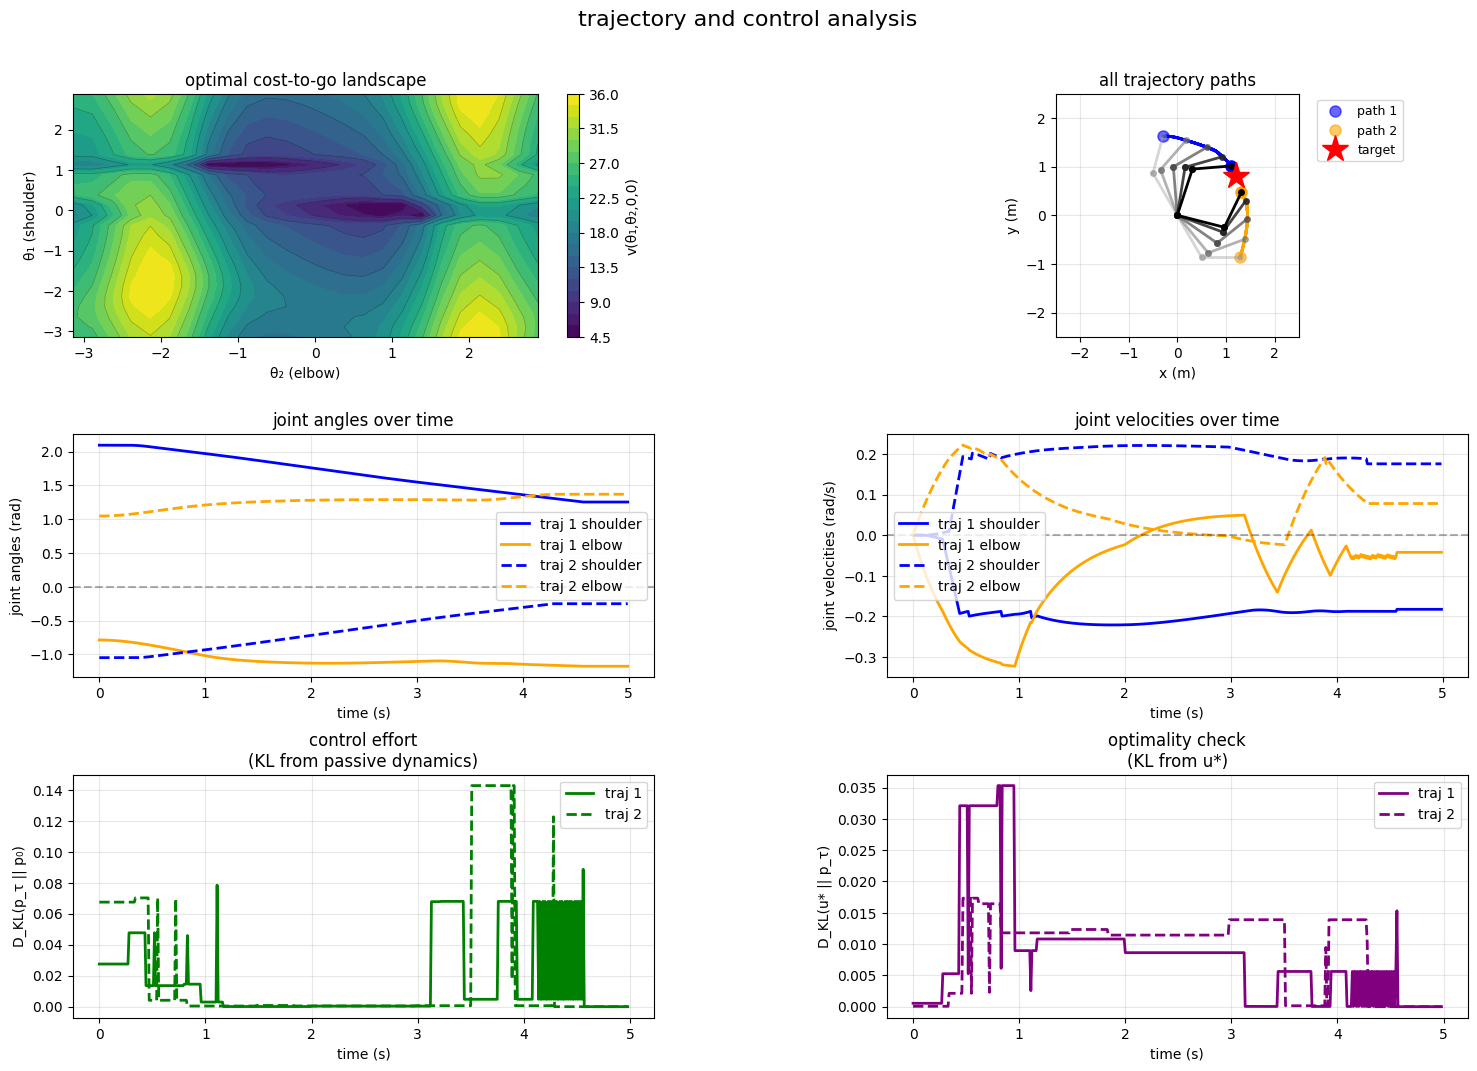

In [3]:
print("=" * 50)
print("simple reaching (no obstacle)")
print("=" * 50)
mdp1, z1, trajs1 = run_reaching_experiment(with_obstacle=False)
plt.show()


reaching with obstacle
building passive kernel for 180625 states...
P0 support (all states/rows): mean=58.40, std=17.51, min=9, max=96, n=180625
setting costs and boundaries...
solving kl control problem...
simulating from start [ 2.0943951  -0.78539816]...
simulating from start [-1.04719755  1.04719755]...
average KL from optimal controlled dynamics: 0.0897
average KL from passive dynamics (control effort): 0.0633


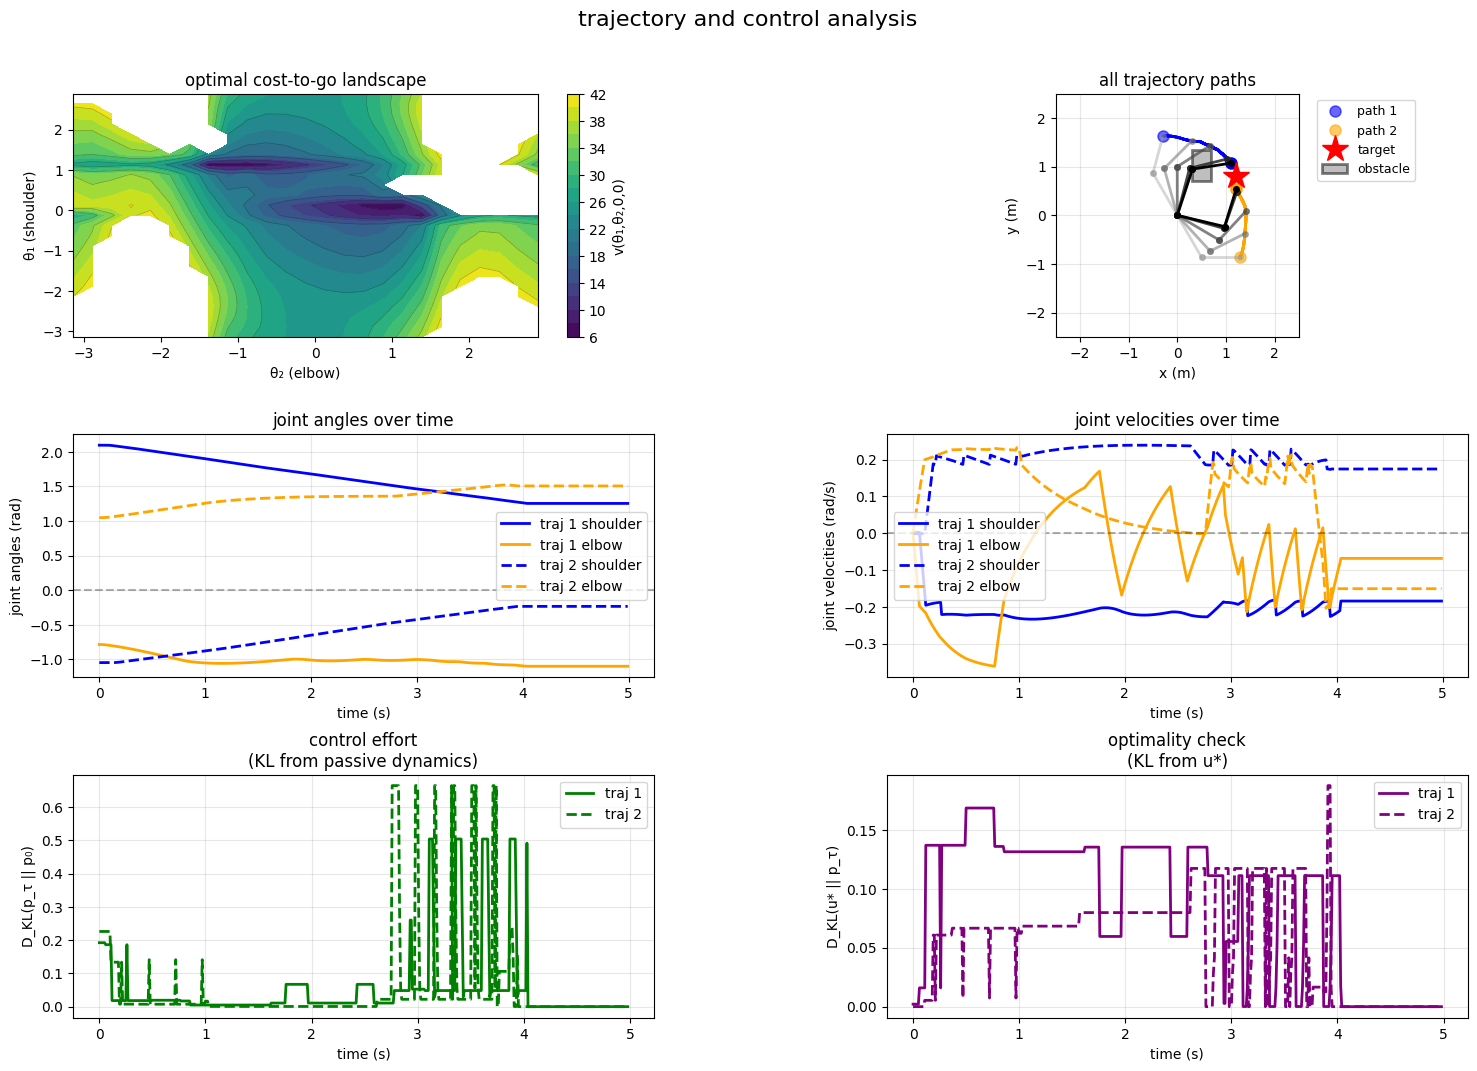

In [6]:
print("\n" + "=" * 50)
print("reaching with obstacle")
print("=" * 50)
mdp2, z2, trajs2 = run_reaching_experiment(with_obstacle=True)
plt.show()

Note that the obstacle costs and running costs can be better tuned to get less jittery responses, but that is not the current focus of this exposition. Note also that $z_k$'s for multiple ($k$) targets can be composed together to form a composite $z$ to function as "goals in parallel", resulting in switching control (see Todorov 2009, NeurIPS).